In [1]:
#requires NLTK, BeautifulSoup
import load_data

# Parse data from ../data/processed

In [2]:
reload(load_data)
pres_dict = load_data.read_processed_data("../data/processed/")
load_data.print_dict(pres_dict)

Processing ../data/processed/ ...
Donald J. Trump: vocab count 14182, sentence count 4422, word count 65082
Barack Obama: vocab count 15164, sentence count 3142, word count 64092


# Parse json data from ../data/unprocessed

In [3]:
load_data.read_unprocessed_data(pres_dict, "../data/unprocessed/")
load_data.print_dict(pres_dict)

Processing ../data/unprocessed/ ...
Lyndon B. Johnson: vocab count 118961, sentence count 22235, word count 445977
George Bush: vocab count 87076, sentence count 21374, word count 385669
Richard Nixon: vocab count 40528, sentence count 7426, word count 191118
Franklin D. Roosevelt: vocab count 123191, sentence count 16084, word count 399627
William J. Clinton: vocab count 73996, sentence count 16625, word count 359552
Harry S. Truman: vocab count 139865, sentence count 31957, word count 413257
Gerald R. Ford: vocab count 34320, sentence count 6283, word count 135621
John F. Kennedy: vocab count 61138, sentence count 11051, word count 258231
Dwight D. Eisenhower: vocab count 161616, sentence count 22835, word count 601774
Ronald Reagan: vocab count 48017, sentence count 8770, word count 192872
George W. Bush: vocab count 71606, sentence count 20821, word count 361515
Herbert Hoover: vocab count 74728, sentence count 3027, word count 103986
Barack Obama: vocab count 203362, sentence coun

# Set up train and test data
This part of code will use num_of_words and the threshold of words to select from each president speeches. If a president doesn't have word counts (less than num_of_words), he will be skipped.

The data will be converted into 2d matrix give a batch size, and then split into 80% for training and 20% for test

In [4]:
words_per_batch = 200
num_of_words = 102000
president_int, vocab_size, y_train, X_train, y_test, X_test = load_data.create_train_test_data(pres_dict, num_of_words, words_per_batch)

# X_train.shape = (1407, 100): the number of original words were 140700. They were broken into batches of 100
# y_train.shape = (1407, 4): each batch is mapped to 1 of the 4 presidents
print vocab_size, X_train.shape, y_train.shape, X_test.shape, y_test.shape

Max number of words: 102000
Processing data for Lyndon B. Johnson
Processing data for George Bush
Processing data for Richard Nixon
Processing data for Franklin D. Roosevelt
Processing data for William J. Clinton
Processing data for Harry S. Truman
Processing data for Gerald R. Ford
Processing data for John F. Kennedy
Processing data for Dwight D. Eisenhower
Processing data for Ronald Reagan
Processing data for George W. Bush
Processing data for Herbert Hoover
Processing data for Barack Obama
Processing data for Donald J. Trump
Processing data for Jimmy Carter
31303 (6120, 200) (6120, 15) (1530, 200) (1530, 15)


# Create Keras Model as a baseline and Training

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Embedding
from keras.utils import np_utils
'''
# Instantiate and build model
model = Sequential()
model.add(Embedding(num_of_words, batch_size))
model.add(LSTM(100, input_shape=(None,batch_size)))
model.add(Dense(units=len(president_int.keys())))
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
print(model.summary())

# Train
print "Training..."
model.fit(X_train, y_train, epochs=10, batch_size=words_per_batch*10)
'''

Using TensorFlow backend.


'\n# Instantiate and build model\nmodel = Sequential()\nmodel.add(Embedding(num_of_words, batch_size))\nmodel.add(LSTM(100, input_shape=(None,batch_size)))\nmodel.add(Dense(units=len(president_int.keys())))\nmodel.compile(loss=\'categorical_crossentropy\', optimizer=\'SGD\', metrics=[\'accuracy\'])\nprint(model.summary())\n\n# Train\nprint "Training..."\nmodel.fit(X_train, y_train, epochs=10, batch_size=words_per_batch*10)\n'

# Another simpler Model

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Embedding
from keras.utils import np_utils
# Instantiate and build model
model = Sequential()
model.add(Dense(units=400, input_dim=words_per_batch))
model.add(Activation('tanh'))
model.add(Dense(units=400, input_dim=200))
model.add(Activation('tanh'))
model.add(Dense(units=400, input_dim=200))
model.add(Activation('tanh'))
model.add(Dense(units=len(president_int.keys())))
model.add(Activation('softmax'))

# Compile w/ chosen loss, optimization fns; specific output metrics
model.compile(loss='categorical_crossentropy',
              optimizer='Adagrad',
              metrics=['categorical_accuracy','accuracy'])
print(model.summary())

# Train
print "Training..."
model.fit(X_train, y_train, epochs=50, batch_size=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               80400     
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
activation_2 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
activation_3 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)                6015      
__________

# Test and predict

In [7]:
# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=words_per_batch)

# Make some predictions
print "\n\nPredicting using test data..."
predictions = model.predict(X_test, batch_size=words_per_batch)

#print (classes)

print "\n\n",model.metrics_names
print loss_and_metrics


def prediction_to_01(predictions):
    max_p = predictions.max(axis=1)
    pred_int = None
    for i in range(len(max_p)):
        pred_int = load_data.append_matrices(pred_int, [(predictions[i] == max_p[i]).astype(int)])
    return pred_int


pred_y = prediction_to_01(predictions)
#print predictions.shape
#print pred_y
#print y_test

Evaluating test data...
 200/1530 [==>...........................] - ETA: 0s

Predicting using test data...


['loss', 'categorical_accuracy', 'acc']
[4.3863130457261033, 0.073202614057687368, 0.073202614057687368]
(1530, 15)
[[0 0 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[[1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(y_test, axis=1)
print pred_y_collapsed
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)

print president_int, '\n', pres_dict.keys()
#cnf_matrix = confusion_matrix(y_test, pred_y)

[9 2 7 ..., 4 0 6]
{u'Lyndon B. Johnson': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], u'George Bush': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], u'Richard Nixon': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], u'Franklin D. Roosevelt': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], u'William J. Clinton': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], u'Harry S. Truman': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], u'Gerald R. Ford': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], u'John F. Kennedy': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], u'Dwight D. Eisenhower': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], u'Jimmy Carter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], u'George W. Bush': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], u'Herbert Hoover': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 'Barack Obama': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 'Donald J. Trump': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], u'Ronald Reagan': [0, 0, 0, 0, 0, 0, 0, 0, 

Confusion matrix, without normalization
[[ 4  6  8  8  6  8  4  8  4 10  8  9  7  7  5]
 [ 6  7  1  8  7  7  3  7  5 11  9 11  8  6  6]
 [ 0  6  3  5  8 10  8  5  2  9  9 13  8  8  8]
 [ 4  4  4  5  5  5  3  6  6  7 12 13 12  8  8]
 [ 5  6  6  3  8  6 11  8  6 12  6  5  7  6  7]
 [ 2  9  7  5 14 12  5  5  8  8  7  6  6  2  6]
 [ 7  2  4  2  8  9  8  5  3  9  5 11  9 13  7]
 [ 3  6  5  9  8  7  8  4  9 13  8  5  7  2  8]
 [ 2 12  8  6  8  5  6  7 12  7  7  6  7  3  6]
 [ 2  3  9  9  9  4  5  4  4  8  7  8 13  7 10]
 [ 4  4  8  4 11  5  5  5  7  9  9  8  4  9 10]
 [ 6  3  8  7  4  7  6  2 11  7  9  8 11 10  3]
 [ 5  4  7  3  8  6  4  5  8  9  4  6 13 17  3]
 [ 5  7  8  5  4  7  3  4  3 13  8 14  8  6  7]
 [ 6  6  4  8  6  5  4  7  5  7 12 14  7  6  5]]
Normalized confusion matrix
[[ 0.04  0.06  0.08  0.08  0.06  0.08  0.04  0.08  0.04  0.1   0.08  0.09
   0.07  0.07  0.05]
 [ 0.06  0.07  0.01  0.08  0.07  0.07  0.03  0.07  0.05  0.11  0.09  0.11
   0.08  0.06  0.06]
 [ 0.    0.06  0.03  

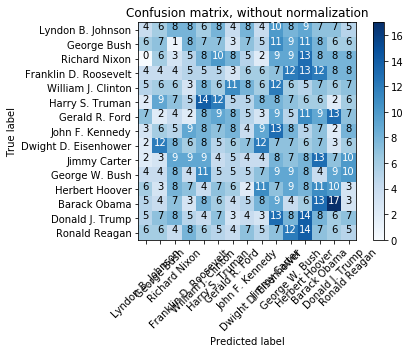

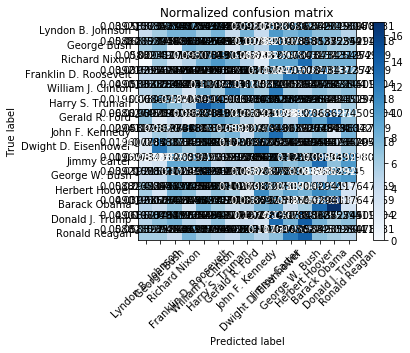

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
load_data.plot_confusion_matrix(cnf_matrix, classes=president_int.keys(),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
load_data.plot_confusion_matrix(cnf_matrix, classes=president_int.keys(), normalize=True,
                      title='Normalized confusion matrix')

plt.show()